In [52]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [53]:
import pandas as pd
import numpy as np
import itertools
import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

In [54]:
from pmdarima.arima import auto_arima
from pmdarima.arima.stationarity import ADFTest
from pmdarima import autocorr_plot

In [55]:
import warnings
warnings.filterwarnings('ignore')

### versions

In [56]:
print('numpy:', np.__version__)
print('scipy:', scipy.__version__)
print('pandas:', pd.__version__)
import sklearn; print('sklearn:', sklearn.__version__)
import statsmodels; print('statsmodels:', statsmodels.__version__)
import pmdarima; print('pmdarima:', pmdarima.__version__)

numpy: 1.19.1
scipy: 1.5.2
pandas: 1.1.1
sklearn: 0.23.2
statsmodels: 0.11.1
pmdarima: 1.7.1


# flight data

### load data, explore, and prepare
### `statsmodels`
- seasonal decomposition with multiplicative model
- seasonal decomposition with additive model   
   
### `pmdarima`
- test for stationarity
- `auto_arima`

# general time series analysis examples
https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

# `pmdarima`
https://alkaline-ml.com/pmdarima/user_guide.html
### previous name `pyramid ARIMA`
### article for this example
https://datafai.com/auto-arima-using-pyramid-arima-python-package/

# load data and explore

In [57]:
flight_data = sns.load_dataset('flights')

In [58]:
flight_data.shape
flight_data.info()
flight_data.head()
flight_data.tail()

(144, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


,year,month,passengers
139,1960,August,606
140,1960,September,508
141,1960,October,461
142,1960,November,390
143,1960,December,432


In [59]:
flight_data.describe()

,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


In [60]:
flight_data_pivot = flight_data.pivot('month', 'year', 'passengers')
flight_data_pivot

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


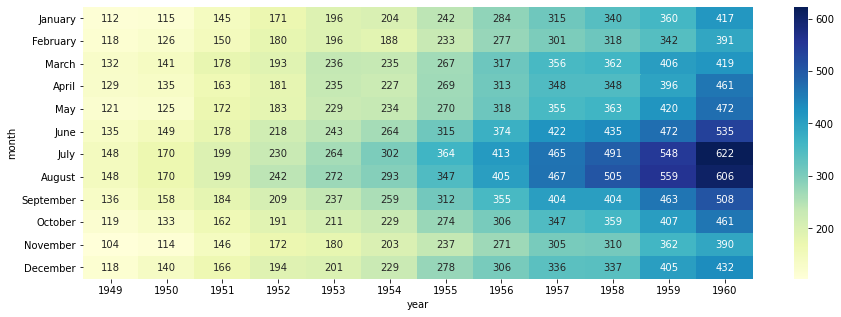

In [61]:
_ = plt.figure(figsize=(15,5))
_ = sns.heatmap(flight_data_pivot, annot=True, fmt='d', cmap='YlGnBu')

### add column for date stamp

In [62]:
month = pd.date_range('19490131', periods=144, freq='M')
month

DatetimeIndex(['1949-01-31', '1949-02-28', '1949-03-31', '1949-04-30',
               '1949-05-31', '1949-06-30', '1949-07-31', '1949-08-31',
               '1949-09-30', '1949-10-31',
               ...
               '1960-03-31', '1960-04-30', '1960-05-31', '1960-06-30',
               '1960-07-31', '1960-08-31', '1960-09-30', '1960-10-31',
               '1960-11-30', '1960-12-31'],
              dtype='datetime64[ns]', length=144, freq='M')

In [63]:
flight_data['datestamp'] = month
flight_data.head()

,year,month,passengers,datestamp
0,1949,January,112,1949-01-31
1,1949,February,118,1949-02-28
2,1949,March,132,1949-03-31
3,1949,April,129,1949-04-30
4,1949,May,121,1949-05-31


### select data for modeling

In [64]:
data = flight_data.loc[:, ('datestamp', 'passengers')]
data.head()
data.describe()

,datestamp,passengers
0,1949-01-31,112
1,1949-02-28,118
2,1949-03-31,132
3,1949-04-30,129
4,1949-05-31,121


,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [65]:
data.set_index('datestamp', inplace=True)
data.head()

,passengers
datestamp,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


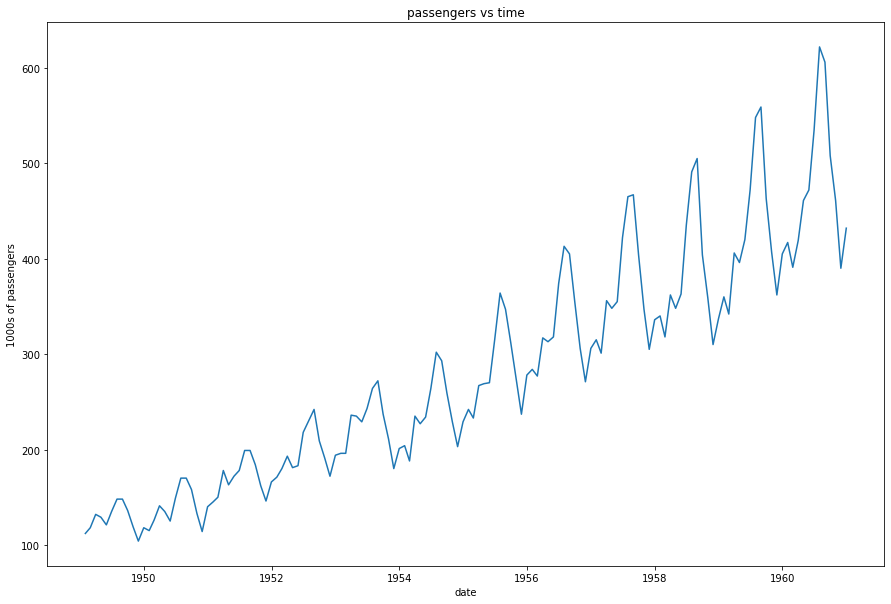

In [66]:
_ = plt.figure(figsize=(15,10))
_ = plt.plot(data)
_ = plt.xlabel('date')
_ = plt.ylabel('1000s of passengers')
_ = plt.title('passengers vs time')

# `statsmodels`
### seasonal decomposition with multiplicative model
https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html   
https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

In [67]:
decomp_mult = seasonal_decompose(data, model='multiplicative')

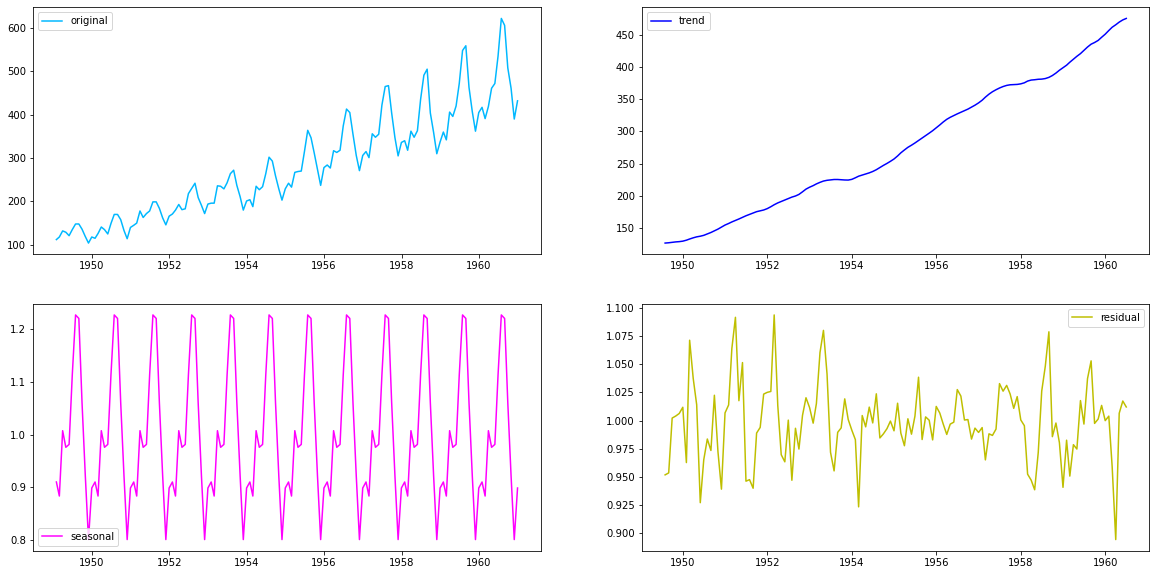

In [68]:
_ = plt.figure(figsize=(20, 10))

_ = plt.subplot(221)
_ = plt.plot(data, color='#00b8ff', label='original')
_ = plt.legend(loc='best')

_ = plt.subplot(222)
_ = plt.plot(decomp_mult.trend, color='b', label='trend')
_ = plt.legend(loc='best')

_ = plt.subplot(223)
_ = plt.plot(decomp_mult.seasonal, color='#ff00ff', label='seasonal')
_ = plt.legend(loc='best')

_ = plt.subplot(224)
_ = plt.plot(decomp_mult.resid, color='y', label='residual')
_ = plt.legend(loc='best')

# `statsmodels`
### seasonal decomposition with additive model

In [69]:
decomp_add = seasonal_decompose(data, model='additive')

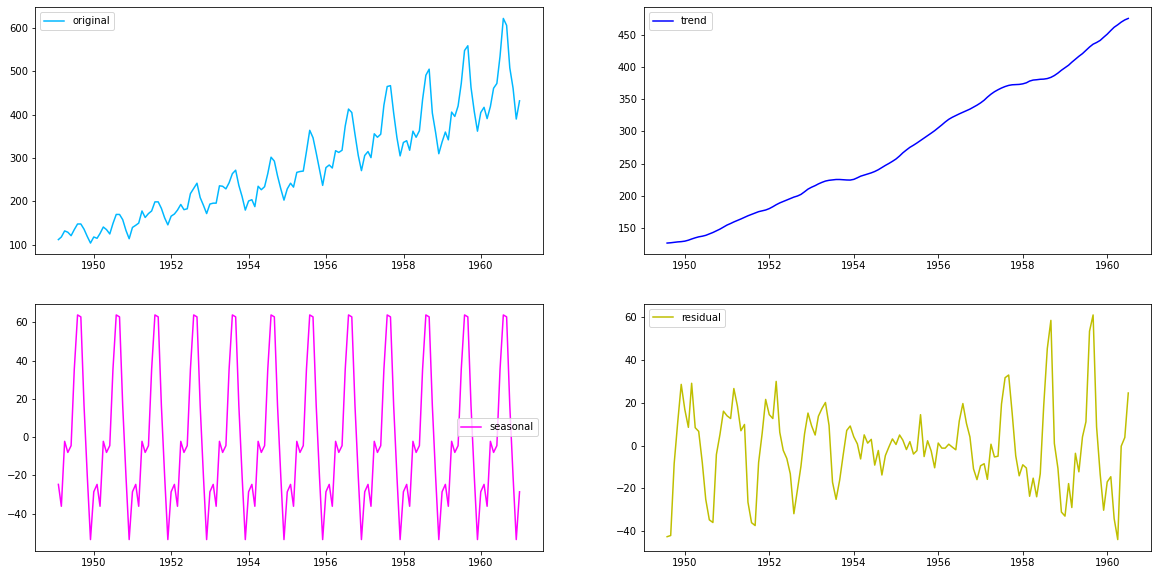

In [70]:
_ = plt.figure(figsize=(20, 10))

_ = plt.subplot(221)
_ = plt.plot(data, color='#00b8ff', label='original')
_ = plt.legend(loc='best')

_ = plt.subplot(222)
_ = plt.plot(decomp_add.trend, color='b', label='trend')
_ = plt.legend(loc='best')

_ = plt.subplot(223)
_ = plt.plot(decomp_add.seasonal, color='#ff00ff', label='seasonal')
_ = plt.legend(loc='best')

_ = plt.subplot(224)
_ = plt.plot(decomp_add.resid, color='y', label='residual')
_ = plt.legend(loc='best')

# `pmdarima`

### test for stationarity

In [71]:
adf_test = ADFTest(alpha=0.05)
#adf_test.is_stationary(data)  # depricated
adf_test.should_diff(data)

(0.01, False)

### train - test split

In [72]:
train = data[:100]
test  = data[100:]
train.shape
test.shape

(100, 1)

(44, 1)

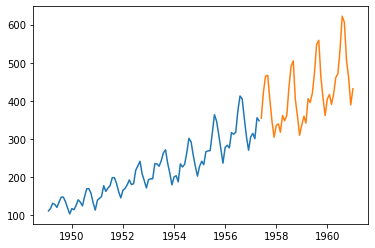

In [73]:
_ = plt.plot(train)
_ = plt.plot(test)

### auto ARIMA
- uses grid search and random search to find best parameters
- `p, d, q` are non-seasonal components
- `P, D, Q` are seasonal components
   
https://alkaline-ml.com/pmdarima/tips_and_tricks.html   
https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima

### fit

In [74]:
arima_model = auto_arima(train,
                         start_p=1, max_p=8, start_q=1, max_q=8, d=1,
                         start_P=1, max_P=8, start_Q=1, max_Q=8, D=1,
                         m=12, seasonal=True, trace=True, stepwise=True,
                         error_action='warn', suppress_warnings=True,
                         random_state=20, n_fits=30)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=647.617, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=650.796, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=644.203, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=644.733, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=645.995, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=646.172, Time=0.32 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=646.187, Time=0.26 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=644.600, Time=0.17 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=647.442, Time=0.09 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=646.085, Time=0.17 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=645.647, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=644.346, Time=0.12 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=647.580, Time=0.33 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

In [75]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -319.101
Date:                            Sun, 29 Nov 2020   AIC                            644.203
Time:                                    10:52:23   BIC                            651.601
Sample:                                         0   HQIC                           647.182
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2434      0.097     -2.512      0.012      -0.433      -0.054
ar.S.L12      -0.2127      0.087     -2.432      0.015      -0.384      -0.041
sigma2        89.1842     14.080      6.334      0.000      61.587     116.781
===================================================================================
Ljung-Box (Q):                       39.35   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.50   Prob(JB):                         0.30
Heteroskedasticity (H):               1.32   Skew:                             0.40
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### predict

In [76]:
test_predict = arima_model.predict(n_periods=test.shape[0])

In [77]:
prediction = pd.DataFrame(test_predict, index=test.index, columns=['predicted_passengers'])
prediction.head()

,predicted_passengers
datestamp,
1957-05-31,353.433649
1957-06-30,406.781321
1957-07-31,447.984392
1957-08-31,438.051605
1957-09-30,391.246543


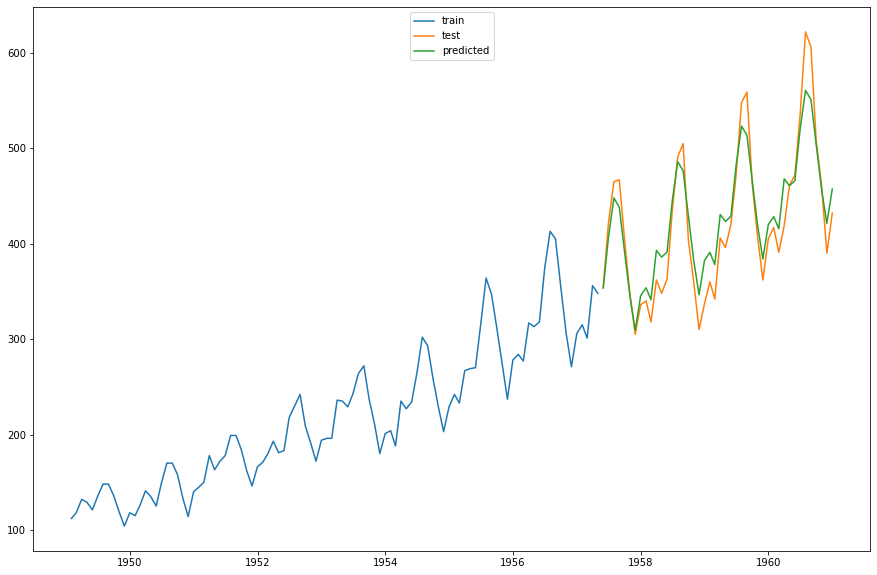

In [78]:
_ = plt.figure(figsize=(15,10))
_ = plt.plot(train, label='train')
_ = plt.plot(test,  label='test')
_ = plt.plot(prediction, label='predicted')
_ = plt.legend(loc='upper center')

### metrics

In [79]:
test['predicted_passengers'] = prediction
test['error'] = test['passengers'] - test['predicted_passengers']
test.head()

,passengers,predicted_passengers,error
datestamp,,,
1957-05-31,355,353.433649,1.566351
1957-06-30,422,406.781321,15.218679
1957-07-31,465,447.984392,17.015608
1957-08-31,467,438.051605,28.948395
1957-09-30,404,391.246543,12.753457


In [80]:
metrics.mean_absolute_error(test['passengers'], test['predicted_passengers'])

21.538631307167854

In [81]:
metrics.mean_squared_error(test['passengers'], test['predicted_passengers'])

686.7476373004326

In [82]:
metrics.median_absolute_error(test['passengers'], test['predicted_passengers'])

22.334088629315573

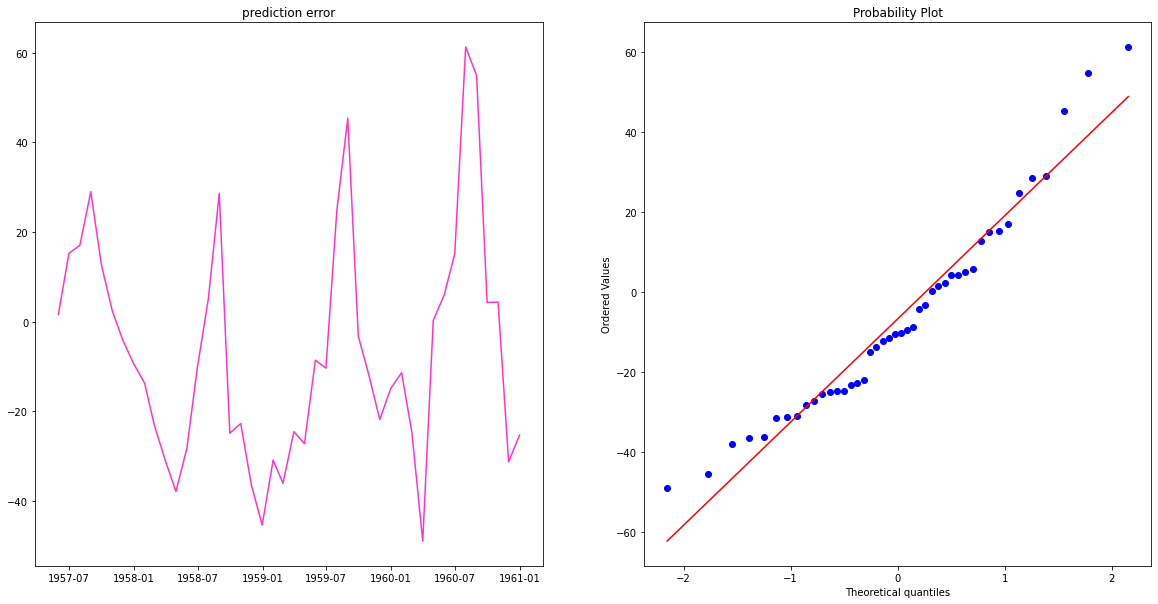

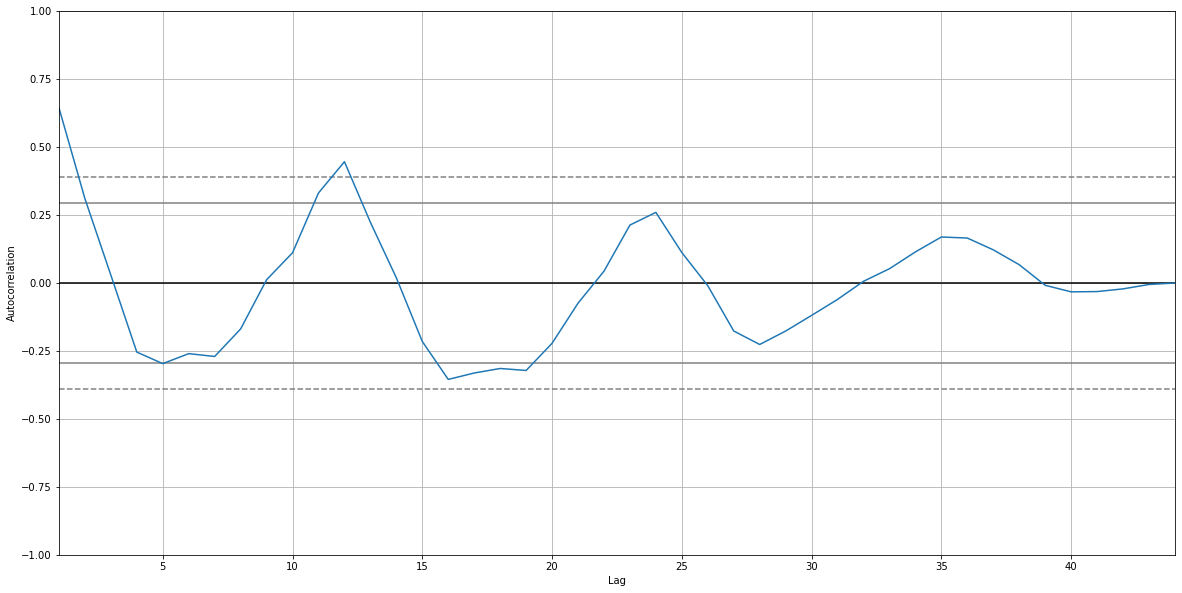

In [83]:
_ = plt.figure(figsize=(20, 10))

_ = plt.subplot(121)
_ = plt.plot(test['error'], color='#ff33CC')
_ = plt.title('prediction error')

_ = plt.subplot(122)
_ = scipy.stats.probplot(test['error'], plot=plt)

_ = plt.figure(figsize=(20, 10))
_ = autocorr_plot(test['error'])